In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [26]:
def initialize(timesteps):
    ''' initialize the physical system, horizontal grid size, etc
    '''  
    # below are the parameters that can be varied
    dx = 1.0
    dz=1.0
    u = 5.0
    v=5.0
    
    dt = dx/ v*0.2
    Numpoints = 30
    shift = Numpoints/5
    c_0 = 1
    alpha = 0.01*10
    epsilon = 0.0001
    
# create the concentration matrix and initialize it
    cmatrix = np.zeros((timesteps+1, Numpoints+4,Numpoints+4))
    cmatrix[0, 5:10,2:Numpoints+2]= c_0 * np.exp(- alpha * (np.arange(0,Numpoints)* dx -shift)**2)
    #for numz in range (Numpoints):
    #    cmatrix[0, 2:Numpoints+2,numz+2]= c_0 * np.exp(- alpha * (np.arange(0,Numpoints)* dx -shift)**2)
    #    cmatrix[0, numz+2,2:Numpoints+2]= c_0 * np.exp(- alpha * (np.arange(0,Numpoints)* dx -shift)**2)
    #print (cmatrix)
    
# set the boundary points
    cmatrix = boundary_conditions(cmatrix, 0, Numpoints)

    return dx,dz, u, v,dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix

def boundary_conditions(cmatrix, time, Numpoints):
    '''Set boundary conditions (double thick so it work for Bott Scheme as well as central and upstream
    '''
    cmatrix[0, 0,:] = cmatrix[1, Numpoints-1,:]
    cmatrix[0, 1,:] = cmatrix[1, Numpoints,:]
    cmatrix[0, Numpoints+2,:] = cmatrix[1, 3,:]
    cmatrix[0, Numpoints+3,:] = cmatrix[1, 4,:]
    
    cmatrix[0, :,0] = cmatrix[1, :,Numpoints-1]
    cmatrix[0, :,1] = cmatrix[1, :,Numpoints]
    cmatrix[0, :,Numpoints+2] = cmatrix[1, :,3]
    cmatrix[0, :,Numpoints+3] = cmatrix[1, :,4]

    return cmatrix

def advect3_gettable(order, Numpoints):
    
    '''read in the corresponding coefficient table for the calculation of coefficients for advection3
    '''

# create a matrix to store the table to be read in
    temp = np.zeros(5)
    ltable = np.zeros((order + 1, 5))

    fname = 'numeric/numlabs/lab10/Tables/l{0}_table.txt'.format(order)
    fp = open(fname, 'r')
 
    for i in range(order+1):
        line = fp.readline()
        temp = line.split()
        ltable[i, :]= temp
        
    fp.close()
    return ltable

In [27]:
def advection3(timesteps, order):
    ''' Entry point for the Bott Scheme'''
    dx, dz,u, v,dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    ltable = advect3_gettable(order, Numpoints)
    cmatrix = step_advect3(timesteps, ltable, cmatrix, order, Numpoints, u, v, dt, dx, dz, epsilon)
    #make_graph(cmatrix, timesteps, Numpoints, dt)
    return cmatrix, timesteps, Numpoints, dt
    

In [29]:
def step_advect3(timesteps, ltable, cmatrix, order, Numpoints, u, v,dt, dx,dz, epsilon):
    '''Step algorithm for Bott Scheme'''
    
# create amatrix to store the current coefficients a(j, k)
    amatrixx = np.zeros((order+1, Numpoints, Numpoints))
    amatrixz = np.zeros((order+1, Numpoints, Numpoints))
    
    for timecount in range(0,timesteps):
        for num in range (Numpoints):
            #calculate amatrix in x dir
            for base in range(0,5):
                amatrixx[0:order+1,0:Numpoints,num] += np.dot(
                    ltable[0:order+2, base:base+1], 
                    cmatrix[timecount:timecount+1, 0+base:Numpoints+base,num])
            #calculate amatriz in z dir
            for base in range(0,5):
                amatrixz[0:order+1,0:Numpoints,num] += np.dot(
                    ltable[0:order+2, base:base+1], 
                    cmatrix[timecount:timecount+1, num, 0+base:Numpoints+base])

    
# calculate I of c at j+1/2(Iplus),  and at j(Iatj)
        Iplusx = np.zeros((Numpoints,Numpoints))
        Iatjx = np.zeros((Numpoints,Numpoints))
        
        Iplusz = np.zeros((Numpoints,Numpoints))
        Iatjz = np.zeros((Numpoints,Numpoints))

        tempvaluex= 1 - 2*u*dt/dx
        tempvaluez= 1 - 2*v*dt/dz
        
        for k in range(order+1):
            for num in range (Numpoints):
                Iplusx += amatrixx[k,:,num] * (1- (tempvaluex**(k+1)))/(k+1)/(2**(k+1))*dz
                Iatjx += amatrixx[k,:,num] * ((-1)**k+1)/(k+1)/(2**(k+1))*dz
                
                Iplusz += amatrixz[k,:,num] * (1- (tempvaluez**(k+1)))/(k+1)/(2**(k+1))*dx
                Iatjz += amatrixz[k,:,num] * ((-1)**k+1)/(k+1)/(2**(k+1))*dx
                
        Iplusx[Iplusx < 0] = 0
        Iatjx = np.maximum(Iatjx, Iplusx + epsilon)
        
        Iplusz[Iplusz < 0] = 0
        Iatjz = np.maximum(Iatjz, Iplusz + epsilon)
    
# finally, calculate the current concentration
        for numx in range (Numpoints-1):
            for numz in range (Numpoints-1):
                cmatrix[timecount+1, 3+numx,3+numz] =  \
                 cmatrix[timecount, 3+numx,3+numz]\
                -cmatrix[timecount, 3+numx,3+numz]*Iplusx.T[1+numx,1+numz]/ Iatjx.T[1+numx,1+numz]*dz\
                +cmatrix[timecount, 3+numx,2+numz]*Iplusx.T[1+numx,0+numz]/Iatjx.T[1+numx,0+numz]*dz\
                -cmatrix[timecount, 3+numx,3+numz]*Iplusz[1+numx,1+numz]/ Iatjz[1+numx,1+numz]*dx\
                +cmatrix[timecount, 2+numx,3+numz]*Iplusz[0+numx,1+numz]/Iatjz[0+numx,1+numz]*dx
               
        # set the boundary condition at the first point
        cmatrix[timecount+1, 2,:]= cmatrix[timecount+1, Numpoints+1,:]
        cmatrix[timecount+1, :,2]= cmatrix[timecount+1, :,Numpoints+1]
        # set the other boundary points
        cmatrix = boundary_conditions(cmatrix, timecount+1, Numpoints)
    return cmatrix


def plotbathy(Hu,x,y,timestep,j1,j2,j3):
    
    
    #fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(j1, j2, j3+1, projection='3d')
    X = np.linspace(0, x,x,endpoint=False)
    Y = np.linspace(0, y,y,endpoint=False)
    X, Y = np.meshgrid(X, Y)
    Z = Hu[timestep,2:-2:,2:-2:]#(Hu**2+Hv**2)**0.5
    
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.05)
    cset = ax.contour(X, Y, Z, zdir='z', offset=Z.max(), cmap=cm.coolwarm,alpha=0.3)
    cset = ax.contour(X, Y, Z, zdir='x', offset=X.min(), cmap=cm.coolwarm,alpha=0.3)
    cset = ax.contour(X, Y, Z, zdir='y', offset=Y.max(), cmap=cm.coolwarm,alpha=0.3)
    ax.set_title('t:%s'%timestep)
    #ax.set_xlabel('X')
    #ax.set_ylabel('Y')
    #ax.set_zlabel('t:%s'%timestep)
    ax.invert_zaxis()

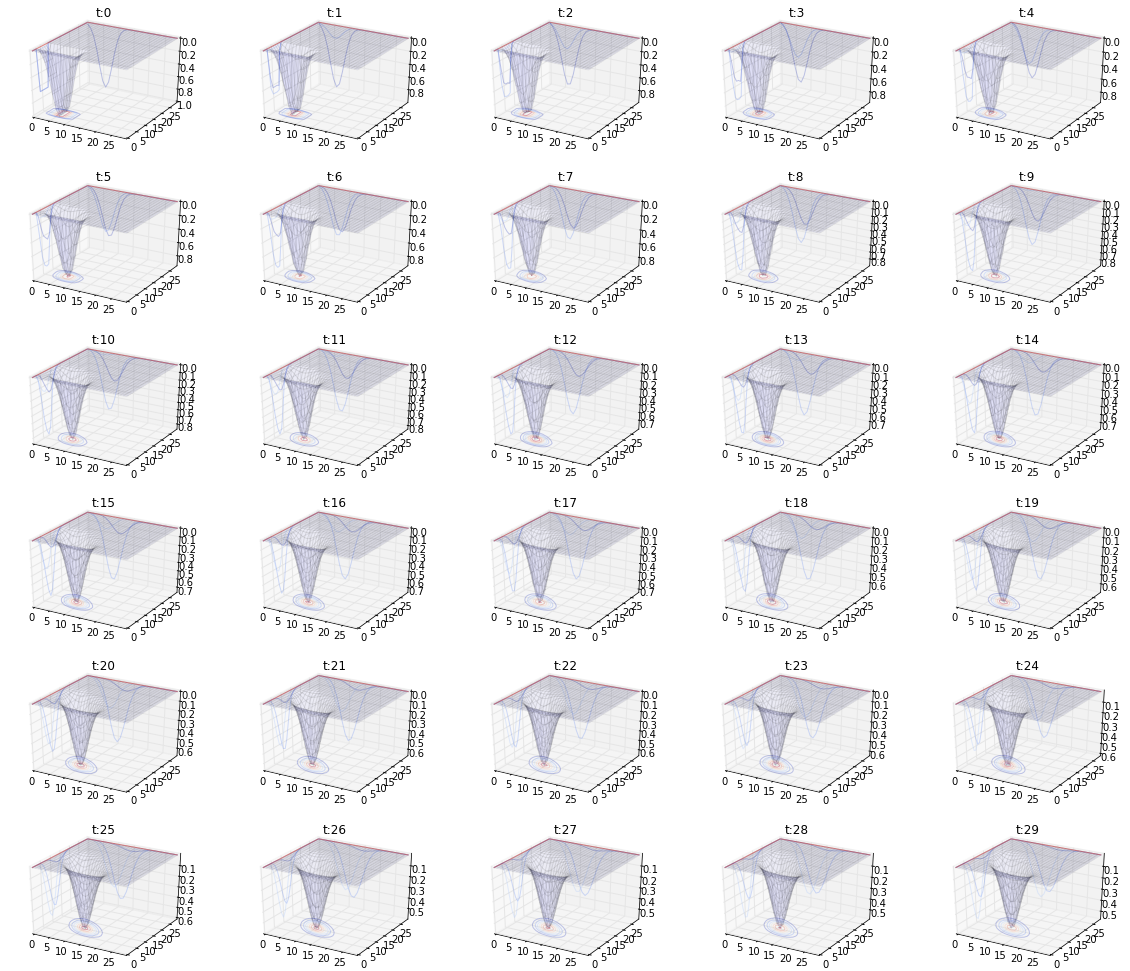

In [30]:
%matplotlib inline
coeff=10
t=30*coeff
a1,b1,c1,d1=advection3(t,4) #24*3600*20,24h
fig = plt.figure(figsize=(20,20))
for j in range (t):
    k=j%coeff
    if k==0:
        plotbathy(a1,30,30,timestep=j/coeff,j1=7,j2=5,j3=j/coeff)
plt.show()